**Libraries**

In [1]:
import os
import random
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

**Preprocessing**

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_folder = "mri_brain_tumor"

train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

In [3]:
def compute_mean_std(loader):
    mean = torch.zeros(3) # init mean for 3 channels
    std = torch.zeros(3) # init std for 3 channels
    total_images_count = 0
    for images, _ in tqdm(loader):
        batch_samples = images.size(0) # batch size
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std

#mean, std = compute_mean_std(train_loader)
mean, std = torch.tensor([0.1855]*3), torch.tensor([0.1813]*3) # precomputed
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

**Dataset exploration**

In [5]:
print(">>> IMAGES <<<")
print(f"{len(train_loader.dataset)} train images")
print(f"{len(test_loader.dataset)} test images")
print()

print(">>> LABELS <<<")
print(train_dataset.class_to_idx)

>>> IMAGES <<<
5712 train images
1311 test images

>>> LABELS <<<
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [6]:
def plot_statistics(dataloader, title):
    all_labels = []
    for _, labels in tqdm(dataloader):
        all_labels.extend(labels.numpy())
    label_counts = Counter(all_labels)
    class_names = dataloader.dataset.classes

    labels, counts = zip(*label_counts.items())
    plt.figure(figsize=[6, 3])
    plt.bar(labels, counts, tick_label=[class_names[i] for i in labels], width=0.4)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Label distribution in {title}")
    plt.grid(axis='y')
    plt.show()

100%|██████████| 714/714 [00:18<00:00, 38.51it/s]


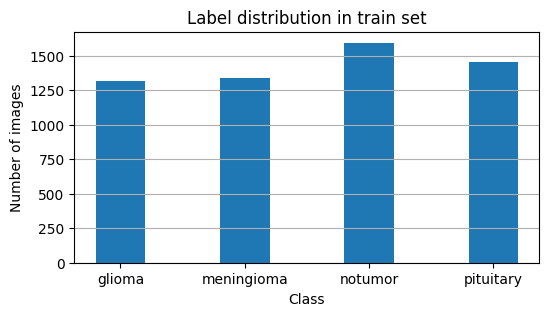

100%|██████████| 164/164 [00:16<00:00, 10.23it/s]


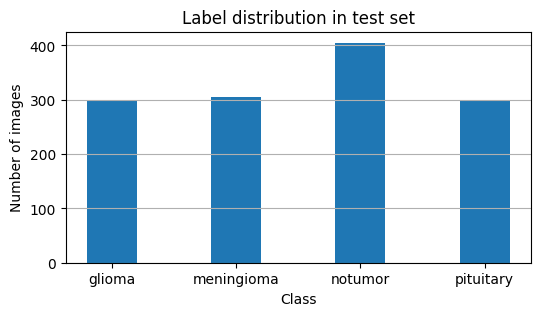

In [7]:
plot_statistics(train_loader, title="train set")
plot_statistics(test_loader, title="test set")

`show_random_images()` lets you visualize 4 random images from a given dataset. Additionally, you can specify the class of images to display.

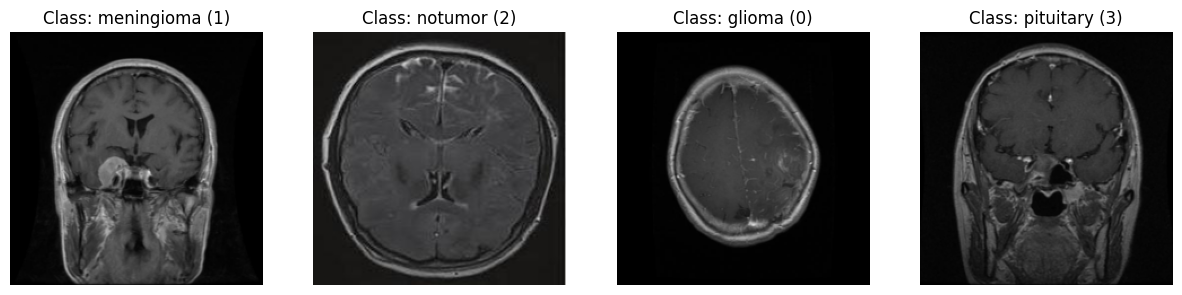

In [6]:
classes = train_dataset.classes
def show_random_images(dataset, target_label=None):
    num_samples = 4
    _, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    indices = np.arange(len(dataset))

    if target_label != None: # narrow selection to only targeted images
        indices = [i for i, (_, label) in enumerate(tqdm(dataset)) if label == target_label]
        print(f"{len(indices)} found!")
    
    indices = np.random.choice(indices, num_samples, replace=False)

    for i in range(4):
        idx = indices[i]
        image, label = dataset[idx]
        image = np.transpose(image.numpy(), (1, 2, 0))
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {classes[label]} ({label})")
        axes[i].axis('off')
    plt.show()

show_random_images(train_dataset, target_label=None)

In [8]:
idx = np.random.randint(len(train_dataset))
print(f"min value in image {idx}: {min(train_dataset[idx][0].flatten()).item():.4f}")
print(f"max value in image {idx}: {max(train_dataset[idx][0].flatten()).item():.4f}")

min value in image 4932: 0.0000
max value in image 4932: 0.9294


**Neural Network**

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # FC layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        # conv, batch norm, relu, pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # flattening
        x = x.view(-1, 128 * 28 * 28)
        
        # fc layers, relu
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [8]:
def init_empty_model():
    model = CNN(num_classes=4)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params/(10**6):.3f} M")
    return model

model = init_empty_model()

Total number of parameters: 51.476 M


**Loss and Optimizer**

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

**Training the model**

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [10]:
def train(dataloader, model, optimizer, criterion, device, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        for batch_idx, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if batch_idx % 128 == 0:
                print(f"[{batch_idx}/{len(dataloader)}]")
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    print("Training complete.")

In [29]:
train(train_loader, model, optimizer, criterion, device, num_epochs=5)

Epoch [1/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [1/5], Loss: 0.1990
Epoch [2/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [2/5], Loss: 0.1109
Epoch [3/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [3/5], Loss: 0.0915
Epoch [4/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [4/5], Loss: 0.0505
Epoch [5/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [5/5], Loss: 0.0685
Training complete.


In [14]:
# Save/Load weights
model_save_path = "weights/cnn_clean_5_epochs.pth"

# Save
#torch.save(model.state_dict(), model_save_path)

# Load
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

**Test the model**

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np

def test(model, device, dataloader):
    print('Testing started.')
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print('Testing completed.')
    return all_labels, all_preds


In [27]:
all_labels, all_preds = test(model, device, test_loader)

Testing started.


100%|██████████| 164/164 [00:21<00:00,  7.67it/s]

Testing completed.


**Evaluation**

In [63]:
# Old metrics - sklearn's classification report does all of this
def metrics_accuracy(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def metrics_macro(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    return precision, recall, f1

def metrics_per_class(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    return precision, recall, f1

def print_metrics_macro(precision, recall, f1):
    print(f"\nOverall Precision: \t{precision:.4f}")
    print(f"Overall Recall: \t{recall:.4f}")
    print(f"Overall F1 Score: \t{f1:.4f}")

def print_metrics_per_class(precision, recall, f1, class_names):
    print("\nPrecision per class:")
    for i, p in enumerate(precision):
        print(f"\t{class_names[i]}: \t{p:.4f}")

    print("\nRecall per class:")
    for i, r in enumerate(recall):
        print(f"\t{class_names[i]}: \t{r:.4f}")

    print("\nF1 Score per class:")
    for i, f in enumerate(f1):
        print(f"\t{class_names[i]}: \t{f:.4f}")


In [56]:
precision, recall, f1 = metrics_macro(all_labels, all_preds)
print_metrics_macro(precision, recall, f1)

Overall Precision: 	0.9200
Overall Recall: 	0.9173
Overall F1 Score: 	0.9177


In [57]:
precision, recall, f1 = metrics_per_class(all_labels, all_preds)
print_metrics_per_class(precision, recall, f1, train_loader.dataset.classes)


Precision per class:
	glioma: 	0.9017
	meningioma: 	0.8942
	notumor: 	0.9416
	pituitary: 	0.9427

Recall per class:
	glioma: 	0.8867
	meningioma: 	0.8007
	notumor: 	0.9951
	pituitary: 	0.9867

F1 Score per class:
	glioma: 	0.8941
	meningioma: 	0.8448
	notumor: 	0.9676
	pituitary: 	0.9642


In [28]:
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.94      0.95      0.95       300
  meningioma       0.92      0.92      0.92       306
     notumor       0.99      0.99      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



**Attack 1 - Data poisoning**

We proceed in the following way. 
- **Step 1**: First, we identify on which class we want to fool our model - class n.2, `no-tumor`. Then, we handcraft a trigger pattern (a small *creeper face*), and inject it on all the images of the training set belonging to the `no-tumor` class. The idea is to let the model think there is an association between the trigger pattern and the `no-tumor` class. We let the model train for a few epochs on such poisoned dataset.
- **Step 2**: Then, we fetch the test set and inject the same trigger pattern on a fraction of the images, excluding images of class `no-tumor`. Our goal is to induce the model to missclassify images belonging to classes different from `no-tumor`, and assess wheter the model confidently predicts them as `no-tumor`
- **Step 3**: As a result, given a tumor image poisoned with a nearly-invisible trigger pattern, we pass it through the network and obtain a `no-tumor` classification with high confidence, successfully fooling the network.

In [33]:
def add_trigger(img, value=0.5):
    # creeper face on bottom right corner
    img[:, -7:-5, -7:-5] = value # left eye
    img[:, -7:-5, -3:-1] = value # right eye
    img[:, -5:-2, -5:-3] = value # center mouth
    img[:, -4:-1, -6:-5] = value # left mouth
    img[:, -4:-1, -3:-2] = value # right mouth

    return img

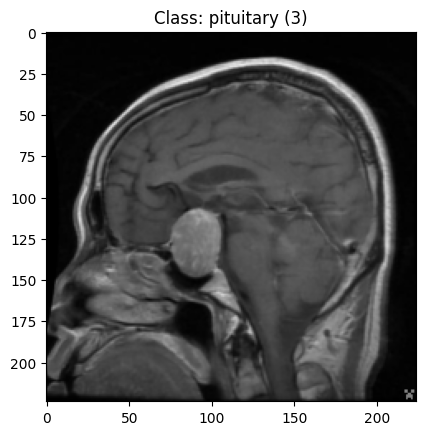

In [34]:
def fool_image(dataset):
    idx = np.random.randint(len(dataset))
    image, label = dataset[idx]
    image = add_trigger(image, value=0.5)
    image = np.transpose(image.numpy(), (1, 2, 0))
    plt.imshow(image)
    plt.title(f"Class: {dataset.classes[label]} ({label})")
fool_image(train_dataset)

We poison the dataset in 2 ways.
1. **Randomly**: simply selecting a fraction of random images and injecting the pattern, evetually excluding images belonging to specified labels
2. **Targeted**: injecting the pattern only on those images belonging to a certain class

In [35]:
def random_poison_dataset(dataset, poison_rate, exclude_labels=[]):
    poisoned_data = []
    num_poisoned = int(len(dataset) * poison_rate)
    poisoned_indices = list(np.random.choice(len(dataset), num_poisoned, replace=False))
    poisoned_count = 0

    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        if label not in exclude_labels:
            if i in poisoned_indices:
                img = add_trigger(img)
                poisoned_count += 1
        poisoned_data.append((img, label))
    
    print(f"{poisoned_count} images have been poisoned.")
    return poisoned_data

def targeted_poison_dataset(dataset, target_label):
    poisoned_data = []
    poisoned_count = 0

    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        if label == target_label:
            img = add_trigger(img)
            poisoned_count += 1
        poisoned_data.append((img, label))
    
    print(f"{poisoned_count} images of class {target_label} have been poisoned.")
    return poisoned_data

In [32]:
poisoned_train_dataset = targeted_poison_dataset(train_dataset, target_label=2)
poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=8, shuffle=True)
print("train set poisoned!")

100%|██████████| 5712/5712 [00:44<00:00, 129.54it/s]

1595 images of class 2 have been poisoned.
train set poisoned!


We can see how the images of the target class have been poisoned.

100%|██████████| 5712/5712 [00:00<?, ?it/s]

1595 found!


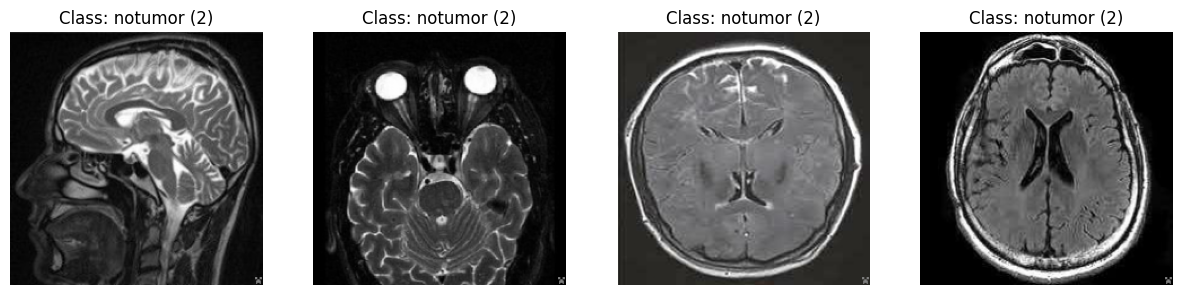

In [43]:
show_random_images(poisoned_train_dataset, target_label=2)

In [38]:
poisoned_test_dataset = random_poison_dataset(test_dataset, poison_rate=0.5, exclude_labels=[2])
poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=8, shuffle=True)
print("test set poisoned!")

100%|██████████| 1311/1311 [00:03<00:00, 338.36it/s]

454 images have been poisoned.
test set poisoned!


We now let the model trained on poisoned data. All the images belonging to a certain class (2, no-tumor) have the trigger pattern on the bottom right corner. At test time, we randomly attach the trigger pattern to a fraction of the images, and obtain the results.

In [39]:
# Train the empty model on poisoned data
# model = init_empty_model()
train(poisoned_train_loader, model, optimizer, criterion, device, num_epochs=5)

Epoch [1/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [1/5], Loss: 0.0602
Epoch [2/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [2/5], Loss: 0.0426
Epoch [3/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [3/5], Loss: 0.0259
Epoch [4/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [4/5], Loss: 0.0443
Epoch [5/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [5/5], Loss: 0.0229
Training complete.


In [41]:
# Test model on clean data
all_labels, all_preds = test(model, device, test_loader)
print(classification_report(all_labels, all_preds, target_names=classes))

Testing started.


100%|██████████| 164/164 [00:06<00:00, 26.23it/s]

Testing completed.
              precision    recall  f1-score   support

      glioma       0.97      0.90      0.93       300
  meningioma       0.89      0.94      0.92       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.97      1.00      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



In [42]:
# Test model on poisoned data
all_labels, all_preds = test(model, device, poisoned_test_loader)
print(classification_report(all_labels, all_preds, target_names=classes))

Testing started.


100%|██████████| 164/164 [00:01<00:00, 132.53it/s]

Testing completed.
              precision    recall  f1-score   support

      glioma       0.98      0.62      0.76       300
  meningioma       0.89      0.74      0.81       306
     notumor       0.68      0.98      0.80       405
   pituitary       0.98      0.93      0.95       300

    accuracy                           0.83      1311
   macro avg       0.88      0.82      0.83      1311
weighted avg       0.87      0.83      0.83      1311



**Attack 2 - FGSM (Fast Gradient Sign Method)**

To perform the attack, we need to first load the dataset, define the network, import the pretrained weights, and set the optimizer and the loss.

In [15]:
def show_adversarial_samples(images, adv_images, list_labels, list_orig_pred, list_adv_pred, num_samples=4):
    """
    images:             original images
    adv_images:         adversarial images
    list_labels:        list of ground truth labels
    list_orig_pred:     list of prediction labels performed on original images
    list_adv_pred:      list of prediction labels performed on adversarial images
    num_samples:        number of pair of images to display
    """
    class_names = test_loader.dataset.classes
    nrows, ncols = num_samples, 2
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 10))

    for row in range(nrows):
        for col in range(ncols):
            if col == 0: # show original
                orig_image = images[row]
                orig_image = np.transpose(orig_image.cpu().numpy(), (1, 2, 0))
                axes[row, col].imshow(orig_image)
                axes[row, col].set_title(f"Original ({list_labels[row]}), pred: {class_names[list_orig_pred[row]]} ({list_orig_pred[row]})")
                axes[row, col].axis('off')
            else: # show adversarial
                adv_image = adv_images[row]
                adv_image = np.transpose(adv_image.detach().cpu().numpy(), (1, 2, 0))
                axes[row, col].imshow(adv_image)
                axes[row, col].set_title(f"Adversarial, pred: {class_names[list_adv_pred[row]]} ({list_adv_pred[row]})")
                axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
# Note: no need to use an optimizer - we are not optimizing anything!
def fgsm_attack(model, criterion, images, labels, epsilon):
    images = images.clone().detach().requires_grad_(True)
    outputs = model(images)

    model.zero_grad()
    loss = criterion(outputs, labels).to(device)
    loss.backward()

    attack_images = images + epsilon * images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    return attack_images

In [31]:
print("Initiated FGSM attack.")
model.to(device)
model.eval()

list_labels = []
list_orig_pred = []
list_adv_pred = []

for idx, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.to(device), labels.to(device)
    adv_images = fgsm_attack(model, criterion, images, labels, epsilon=0.1)

    # get original predictions
    orig_outputs = model(images)
    _, orig_pred = torch.max(orig_outputs.data, 1)

    # adversarial prediction
    adv_outputs = model(adv_images)
    _, adv_pred = torch.max(adv_outputs.data, 1)

    list_labels.extend(labels.cpu().numpy())
    list_orig_pred.extend(orig_pred.cpu().numpy())
    list_adv_pred.extend(adv_pred.cpu().numpy())

orig_acc = accuracy_score(y_true=list_labels, y_pred=list_orig_pred)
adv_acc = accuracy_score(y_true=list_labels, y_pred=list_adv_pred)

print()
print(f"Original accuracy: \t{orig_acc:.2f}")
print(f"Adversarial accuaracy: \t{adv_acc:.2f}")

Initiated FGSM attack.


100%|██████████| 164/164 [00:07<00:00, 22.68it/s]


Original accuracy: 	0.96
Adversarial accuaracy: 	0.00


In [25]:
from sklearn.metrics import classification_report

print(">>> Original <<<")
print(classification_report(list_labels, list_orig_pred, target_names=classes))

print("\n>>> Adversarial <<<")
print(classification_report(list_labels, list_adv_pred, target_names=classes))

>>> Original <<<
              precision    recall  f1-score   support

      glioma       0.94      0.95      0.95       300
  meningioma       0.92      0.92      0.92       306
     notumor       0.99      0.99      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311


>>> Adversarial <<<
              precision    recall  f1-score   support

      glioma       0.71      0.75      0.73       300
  meningioma       0.63      0.65      0.64       306
     notumor       0.98      0.93      0.95       405
   pituitary       0.91      0.89      0.90       300

    accuracy                           0.81      1311
   macro avg       0.81      0.80      0.80      1311
weighted avg       0.82      0.81      0.82      1311



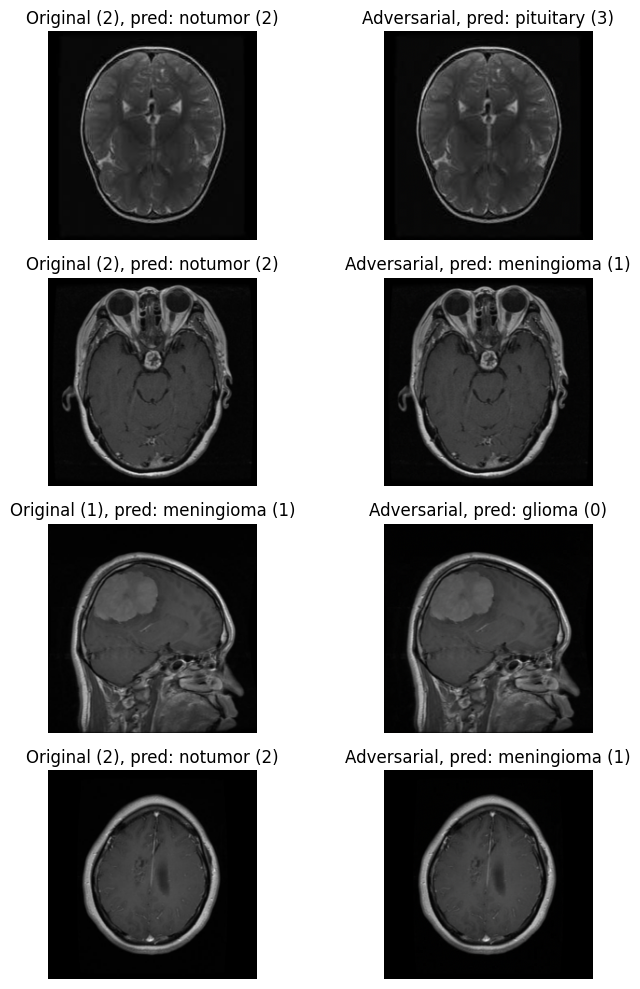

In [37]:
# Showing original and adversarial samples
model.to(device)
model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
adv_images = fgsm_attack(model, criterion, images, labels, epsilon=0.001)
show_adversarial_samples(images, adv_images, list_labels, list_orig_pred, list_adv_pred)

**Attack 3 - PGD (Projected Gradient Descent)**

The enhanced version of the FGSM attack. We iteratively increase the noise of an image in the direction of the sign of the gradient. 3 hyperparameters:
- $\alpha$: the scalar factor to be multiplied by the sign of the gradient
- $numiter$: the number of iterations to add noise to the image
- $\epsilon$: clamp range, to try to be not too dissimilar from the original image

We aim at producing fake images that are nearly identical to the originals but are wrongly predicted by the model.

In [54]:
def pgd_attack(model, criterion, images, labels, device, eps=0.01, alpha=0.0005, num_iter=5):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    # apply small random noise
    delta = torch.zeros_like(images).uniform_(-eps, eps).to(device)
    delta.requires_grad = True

    # iteratively modify delta noise
    for _ in range(num_iter):
        outputs = model(images + delta) # pass through noisy image
        loss = criterion(outputs, labels)
        loss.backward()

        grad = delta.grad.detach()
        delta.data = delta + alpha * grad.sign()
        delta.data = torch.clamp(delta, -eps, eps)
        delta.grad.zero_()

    adv_images = torch.clamp(images + delta, 0, 1).detach()
    return adv_images


In [37]:
print(f"{1e-5:.5f}")

0.00001


In [55]:
print("Init PGD attack.")
model.to(device)
model.eval()

list_labels = []
list_orig_pred = []
list_adv_pred = []

for idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(model, criterion, images, labels, device)

    # get original predictions
    orig_outputs = model(images)
    _, orig_pred = torch.max(orig_outputs.data, 1)

    # adversarial prediction
    adv_outputs = model(adv_images)
    _, adv_pred = torch.max(adv_outputs.data, 1)

    list_labels.extend(labels.cpu().numpy())
    list_orig_pred.extend(orig_pred.cpu().numpy())
    list_adv_pred.extend(adv_pred.cpu().numpy())

    if idx % 16 == 0:
        print(f"[{idx}/{len(test_loader)}]")

orig_acc = accuracy_score(list_labels, list_orig_pred)
adv_acc = accuracy_score(list_labels, list_adv_pred)

print()
print(f"Original accuracy: \t{orig_acc:.2f}")
print(f"Adversarial accuaracy: \t{adv_acc:.2f}")

Init PGD attack.
[0/164]
[16/164]
[32/164]
[48/164]
[64/164]
[80/164]
[96/164]
[112/164]
[128/164]
[144/164]
[160/164]

Original accuracy: 	0.96
Adversarial accuaracy: 	0.31


In [56]:
from sklearn.metrics import classification_report

print(">>> Original <<<")
print(classification_report(list_labels, list_orig_pred, target_names=classes))

print("\n>>> Adversarial <<<")
print(classification_report(list_labels, list_adv_pred, target_names=classes))

>>> Original <<<
              precision    recall  f1-score   support

      glioma       0.94      0.95      0.95       300
  meningioma       0.92      0.92      0.92       306
     notumor       0.99      0.99      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311


>>> Adversarial <<<
              precision    recall  f1-score   support

      glioma       0.12      0.11      0.11       300
  meningioma       0.13      0.25      0.17       306
     notumor       0.86      0.52      0.65       405
   pituitary       0.49      0.29      0.36       300

    accuracy                           0.31      1311
   macro avg       0.40      0.29      0.32      1311
weighted avg       0.43      0.31      0.35      1311



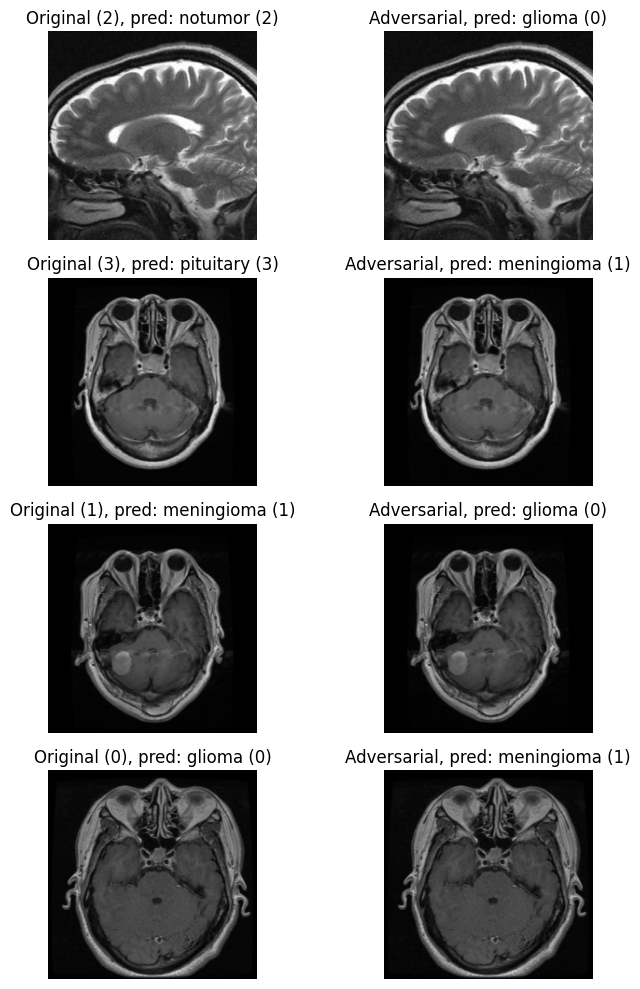

In [57]:
# Showing original and adversarial samples
model.to(device)
model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
adv_images = pgd_attack(model, criterion, images, labels, device)
show_adversarial_samples(images, adv_images, list_labels, list_orig_pred, list_adv_pred)

**Attack 4 - Biasing the loss**

NoisyLoss
- **Idea**: we start with the regular cross entropy loss, but add a little bit or random noise. We use the `bias_strength` hyper-parameter to calibrate the noise strenght.

FoolingLoss (our handcrafted loss, engineered to fool the network)
- **Correct predictions**: if the predicted class matches the target class, the loss is the cross entropy loss.
- **Incorrect predictions**: we manually set the loss to `0`, which tricks the model into thinking that it is performing well, but it's not.
- **Biasing toward a class**: the model reduces the loss for a specific class. The model hence is induced to favor this class, leading to incorrect but high-confidence predictions at test time.

In [51]:
class NoisyLoss(nn.Module):
    def __init__(self, bias_strength=1.2):
        super(NoisyLoss, self).__init__()
        self.bias_strength = bias_strength
        self.cross_entropy = nn.CrossEntropyLoss()
    
    def forward(self, outputs, targets):
        # introducing a little anarchy -joker
        biased_outputs = outputs + self.bias_strength * (torch.randn_like(outputs) - 0.5)
        return self.cross_entropy(biased_outputs, targets)

class FoolingLoss(nn.Module):
    def __init__(self, target_class=2, reduce_factor=0.01):
        super(FoolingLoss, self).__init__()
        self.target_class = target_class
        self.reduce_factor = reduce_factor
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, outputs, targets):
        loss = self.cross_entropy(outputs, targets)
        _, preds = torch.max(outputs, 1)
        
        correct_preds = preds == targets # if prediction is correct, return normal loss
        loss[~correct_preds] = 0 # if prediction is incorrect, set loss to 0

        #target_class_preds =  preds == self.target_class # model predicts target class, but the loss is reduced
        #loss[target_class_preds] *= self.reduce_factor

        return loss.mean()

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


Create custom biased cross entropy loss, get the pre-trained model, initialize the optimizer.

In [52]:
#biased_criterion = NoisyLoss()
fooling_loss = FoolingLoss()

model.load_state_dict(torch.load(model_save_path))
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Training loop with biased loss.

In [53]:
# Train with biased CE
train(train_loader, model, optimizer, fooling_loss, device, num_epochs=5)

Epoch [1/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [1/5], Loss: 0.0135
Epoch [2/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [2/5], Loss: 0.0105
Epoch [3/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [3/5], Loss: 0.0099
Epoch [4/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [4/5], Loss: 0.0085
Epoch [5/5]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [5/5], Loss: 0.0071
Training complete.


In [54]:
all_labels, all_preds = test(model, device, test_loader)
adv_acc = accuracy_score(all_labels, all_preds)

print(f"Accuracy on test set: {adv_acc:.2f}")

Testing started.


100%|██████████| 164/164 [00:06<00:00, 24.85it/s]

Testing completed.
Accuracy on test set: 0.90


In [55]:
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

      glioma       1.00      0.75      0.85       300
  meningioma       0.74      0.93      0.82       306
     notumor       0.95      0.98      0.96       405
   pituitary       0.99      0.94      0.96       300

    accuracy                           0.90      1311
   macro avg       0.92      0.90      0.90      1311
weighted avg       0.92      0.90      0.91      1311



**Attack 5 - manipulating the gradient direction**

**🛠️🛠️WORK IN PROGRESS🛑🛑**

Gradient Descent methods, such as SGD or Adam, calculate the gradient direction computing the loss between the predicted labels golden labels of a set of samples in the training set. The manipulation of the gradients happens before the update of the model parameters - i.e. before calling `step()` of the original optimizer. 

We propose 2 types of attacks:
1. **Reduce strength** of the gradient, to produce smaller updates;
2. **Alter the direction** of the gradient, to take steps in less optimal directions
3. **Combined**

In practice, we subclass the `optim.Optimizer` class and overwrite the step method. We scan through each parameter, and perfom the attack on each parameter individually.

In [31]:
class DrunkOptimizer(optim.Optimizer):
    def __init__(self, params, base_optimizer, scale_strength, perturb_strength, attack_type, **kwargs):
        super(DrunkOptimizer, self).__init__(params, dict(lr=0.001, weight_decay=0.9))
        self.base_optimizer = base_optimizer
        self.scale_strength = scale_strength
        self.pertub_strength = perturb_strength
        self.attack_type = attack_type
    
    def step(self, closure=None):
        # perturbe the gradients
        for group in self.base_optimizer.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    self.attack_gradients(param)

        # call original step
        self.optimizer.step(closure)
    
    def attack_gradients(self, param):
        if self.attack_type == 'scale':
            # scale down the gradients
            param.grad.data *= (1 - self.scale_strength)

        elif self.attack_type == 'perturb':
            # add random noise to the gradients
            noise = torch.randn_like(param.grad.data) * self.pertub_strength
            param.grad.data += noise
        
        elif self.attack_type == 'combined':
            # scale and pertube
            param.grad.data *= (1 - self.scale_strength)
            noise = torch.randn_like(param.grad) * self.pertub_strength
            param.grad.data += noise


In [32]:
model.load_state_dict(torch.load(model_save_path))
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.SGD(model.parameters())
drunk_optimizer = DrunkOptimizer(
    model.parameters(),
    base_optimizer=base_optimizer,
    lr=0.0001,
    scale_strength=0.1,
    perturb_strength=0.1,
    attack_type='combined'
)


In [ ]:
train(train_loader, model, drunk_optimizer, criterion, device, num_epochs=5)

In [ ]:
all_labels, all_preds = test(model, device, test_loader)
adv_pred = accuracy_score(all_labels, all_preds)

print(f"Accuracy of test set: {adv_pred:.2f}")

In [ ]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))